# 📘 Next-Generation Spam Filtering - CNN 中文分類模型（最終版）
本模型使用 TF-IDF 特徵搭配改良後的中文分詞（使用 jieba 分詞、停用詞過濾、保留空格）以提升準確率，
CNN 架構包含兩層卷積 + Global MaxPooling + Dense 層，支援七類中文垃圾郵件分類。

# 📘 Next-Generation Spam Filtering - CNN 中文分類模型
使用 `jieba` 分詞與 TF-IDF 特徵向量，搭配 CNN 進行七類分類。

## 📦 第 1 部分：匯入必要套件

In [1]:

import pandas as pd
import re
import jieba
import numpy as np
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## 📑 第 2 部分：讀取與預處理資料

In [2]:
import pandas as pd
import re
import jieba
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv("test.csv")
df['text'] = df['subject'].fillna('') + ' ' + df['message'].fillna('')

stop_words = set(stopwords.words('english'))  # 可自定義中文停用詞集

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9]', ' ', text)# 保留中英文與數字
    words = jieba.lcut(text)
    return ' '.join([w for w in words if w not in stop_words and len(w) > 1])

df['clean_text'] = df['text'].apply(clean_text)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model cost 0.301 seconds.
Prefix dict has been built successfully.


,subject,message,label,text,clean_text
0,The FuelCell Rebel,全新顏色\n\nNew Balance\nhttps://link.email.newbal...,5,The FuelCell Rebel 全新顏色\n\nNew Balance\nhttps:...,The FuelCell Rebel 全新 顏色 New Balance 男裝 女裝 兒童 ...
1,1111人力銀行推薦 -【桃園台茂店【涮乃葉】兼職人員及大專院校實習】,\n \n 轉寄履歷-簡式版\n\n \n \n ...,3,1111人力銀行推薦 -【桃園台茂店【涮乃葉】兼職人員及大專院校實習】 \n \n ...,1111 人力 銀行 推薦 桃園 台茂店 乃葉 兼職 人員及 大專 院校 實習 轉寄履歷 簡...
2,陳任璿-2025/03/16 履歷職缺配對通知,\n 職缺配對 \n ...,3,陳任璿-2025/03/16 履歷職缺配對通知 \n 職缺配對 ...,2025 03 16 履歷職 缺配 通知 職缺配 寄送 期待 配對 職缺 這些 職位 符合 ...
3,你的 Apple 開立發票通知,\n \n開立發票通知\n\n\n APPLE 帳號dana43261...,2,你的 Apple 開立發票通知 \n \n開立發票通知\n\n\n A...,Apple 開立 發票 通知 開立 發票 通知 APPLE 帳號 dana4326172 g...
4,大谷翔平，準備好續集,The Ohtani Signature Collection\n\nNew Balance...,5,大谷翔平，準備好續集 The Ohtani Signature Collection\n\n...,大谷 翔平 準備 好續 The Ohtani Signature Collection Ne...


## 📊 第 3 部分：類別統計與可視化

In [3]:
# 對每封信件進行斷詞、去除網址與停用詞，並建立清洗後的新欄位
from sklearn.model_selection import train_test_split
from collections import Counter

# 切分資料（80% 訓練，20% 驗證），並保留 label 分布比例
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

# 顯示各類別數量
def print_label_counts(title, y):
    counter = Counter(y)
    print(f"{title}：")
    for label in sorted(counter):
        print(f"類別 {label}：{counter[label]} 筆")

print_label_counts("訓練集 各類別數量", y_train)
print()
print_label_counts("驗證集 各類別數量", y_test)


訓練集 各類別數量：
類別 0：240 筆
類別 1：44 筆
類別 2：338 筆
類別 3：469 筆
類別 4：361 筆
類別 5：243 筆
類別 6：145 筆

驗證集 各類別數量：
類別 0：60 筆
類別 1：11 筆
類別 2：84 筆
類別 3：117 筆
類別 4：91 筆
類別 5：61 筆
類別 6：36 筆


## ✂️ 第 4 部分：分詞、特徵抽取與資料分割

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# 使用 TfidfVectorizer 將文字轉為 5000 維向量
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

## 🧠 第 5 部分：建立 CNN 模型

In [5]:

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(X_train_tfidf.shape[1], 1)),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
        

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4998, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2499, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2497, 128)         24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 7)                 9

## 🔁 第 6 部分：模型訓練

In [6]:

history = model.fit(X_train_tfidf, y_train, validation_data=(X_test_tfidf, y_test), epochs=10, batch_size=32)


Epoch 1/10
58/58 [==============================] - 5s 25ms/step - loss: 1.8387 - accuracy: 0.2837 - val_loss: 1.7751 - val_accuracy: 0.3870
Epoch 2/10
58/58 [==============================] - 1s 23ms/step - loss: 1.6864 - accuracy: 0.3880 - val_loss: 1.5532 - val_accuracy: 0.3783
Epoch 3/10
58/58 [==============================] - 1s 23ms/step - loss: 1.5326 - accuracy: 0.4179 - val_loss: 1.4741 - val_accuracy: 0.4674
Epoch 4/10
58/58 [==============================] - 1s 22ms/step - loss: 1.5004 - accuracy: 0.4266 - val_loss: 1.4504 - val_accuracy: 0.4196
Epoch 5/10
58/58 [==============================] - 1s 22ms/step - loss: 1.4815 - accuracy: 0.4484 - val_loss: 1.4538 - val_accuracy: 0.4196
Epoch 6/10
58/58 [==============================] - 1s 23ms/step - loss: 1.4717 - accuracy: 0.4658 - val_loss: 1.4206 - val_accuracy: 0.4739
Epoch 7/10
58/58 [==============================] - 1s 22ms/step - loss: 1.4436 - accuracy: 0.4821 - val_loss: 1.4051 - val_accuracy: 0.4674
Epoch 8/10
58

## 📈 第 7 部分：訓練過程視覺化

d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36942 (\N{CJK UNIFIED IDEOGRAPH-904E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31243 (\N{CJK UNIFIED IDEOGRAPH-7A0B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\文大專題\program\Lingspam\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  

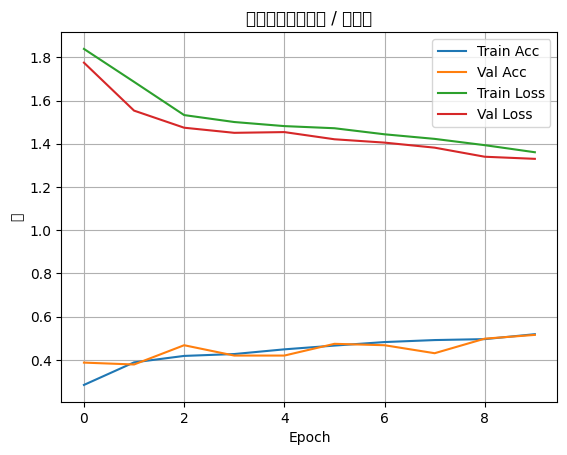

In [7]:

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("訓練過程（準確率 / 損失）")
plt.xlabel("Epoch")
plt.ylabel("值")
plt.legend()
plt.grid(True)
plt.show()


## 📊 第 8 部分：模型評估與混淆矩陣

15/15 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0     0.5652    0.2167    0.3133        60
           1     0.0000    0.0000    0.0000        11
           2     0.4326    0.7262    0.5422        84
           3     0.7429    0.8889    0.8093       117
           4     0.3766    0.6374    0.4735        91
           5     0.5000    0.0164    0.0317        61
           6     0.0000    0.0000    0.0000        36

    accuracy                         0.5152       460
   macro avg     0.3739    0.3551    0.3100       460
weighted avg     0.4825    0.5152    0.4436       460



d:\文大專題\program\Lingspam\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\文大專題\program\Lingspam\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\文大專題\program\Lingspam\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\文大專題\program\Lingspam\.venv\lib\si

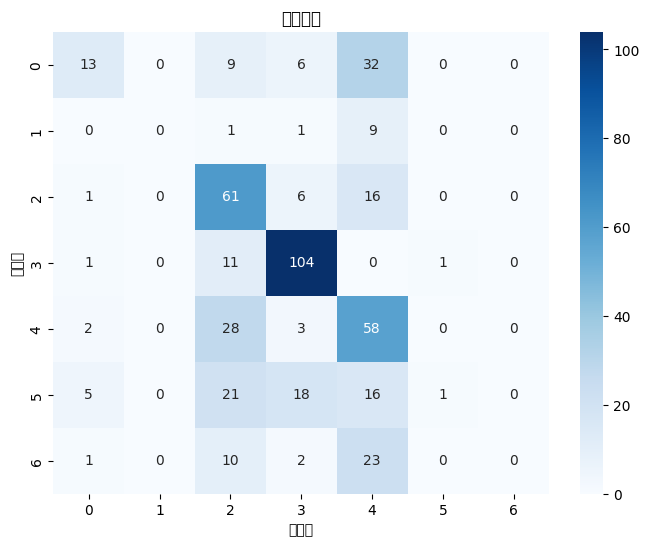

In [8]:

y_pred = model.predict(X_test_tfidf)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels, digits=4))

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("混淆矩陣")
plt.xlabel("預測值")
plt.ylabel("實際值")
plt.show()


## 🔍 附加：單句預測測試

In [9]:

def predict_text(text):
    text_clean = re.sub(r'https?://\S+', '', text)
    text_clean = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9\s]', ' ', text_clean).lower()
    words = jieba.cut(text_clean)
    tokens = " ".join(w for w in words if len(w) > 1 and w not in stopwords)
    vec = vectorizer.transform([tokens]).toarray()
    vec = vec.reshape((1, vec.shape[1]))
    pred = model.predict(vec)
    label = np.argmax(pred)
    print(f"預測類別：{label}（信心值：{pred[0][label]:.4f}）")

# 範例
predict_text("您好，您的驗證碼是123456，請勿告訴他人。")


TypeError: argument of type 'WordListCorpusReader' is not iterable